# Relative run times

Compute run times and computational overhead of perturbation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from seaborn import despine

from itertools import product as itproduct

In [3]:
from neuroprobnum.utils import math_utils
from neuroprobnum.utils import plot_utils as pltu

# Model

In [4]:
from neuroprobnum.models.hodgkin_huxley import compile_cython
compile_cython()

running build_ext



In [5]:
from neuroprobnum.models.hodgkin_huxley import HHNeuron

neuron = HHNeuron()
neuron

HH_neuron

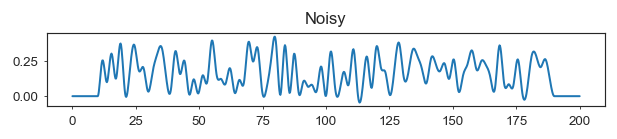

In [6]:
from neuroprobnum.utils import stim_utils

t0, tmax = 0, 200
stim_onset, stim_offset = 10, tmax-10
stims = [
    #stim_utils.IStimStep(Iamp=0.2, onset=stim_onset, offset=stim_offset, name='Step'),
    stim_utils.IStimNoisy(Iamp=0.2, onset=stim_onset, offset=stim_offset, name='Noisy', nknots=101, seed=46),

]
for stim in stims: stim.plot(t0=t0, tmax=tmax)

# Generator

In [7]:
from neuroprobnum.generator.generator_hh import DataGeneratorHH
from copy import deepcopy

gens = {}

for stim in stims:
    
    neuron = deepcopy(neuron)
    neuron.get_Istim_at_t = stim.get_I_at_t
    
    gens[stim] = DataGeneratorHH(
        y0=neuron.compute_yinf(-65), t0=t0, tmax=tmax,
        t_eval_adaptive=math_utils.t_arange(t0, tmax, 1),
        model=neuron, n_samples=100, n_parallel=20, dt_min_eval_fixed=0.1,
        gen_det_sols=True, gen_acc_sols=True, acc_same_ts=True,
        base_folder='data',
    )
    gens[stim].update_subfoldername(stim=stim.name)
    gens[stim].load_acc_sols_from_file()    

## Data

In [8]:
# pert_method, adaptive, methods, step_params, pert_params
solver_params = [
    
    ('abdulle_ln', 0, ['FE', 'EE', 'EEMP', 'RKBS', 'RKCK', 'RKDP'], [0.01], [1]),    
    ('abdulle_ln', 1, ['RKBS', 'RKCK', 'RKDP'], [1e-4], [1]),
    
    ('conrad', 0, ['FE', 'RKBS', 'RKCK', 'RKDP'], [0.01], [1]),
    ('conrad', 1, ['RKBS', 'RKCK', 'RKDP'], [1e-4], [1]),

    (None, 0, ['FE', 'EE', 'EEMP', 'RKBS', 'RKCK', 'RKDP'], [0.01], ['None']),
    (None, 1, ['RKBS', 'RKCK', 'RKDP'], [1e-4], ['None']),
]

In [9]:
for stim, gen in gens.items():
    
    print('----------------------------------------------------------')
    print(stim, ':', gen.subfoldername)
    print('----------------------------------------------------------')   
    
    for pert_method, adaptive, methods, step_params, pert_params in solver_params:
        for step_param, method, pert_param in itproduct(step_params, methods, pert_params):
            gen.gen_and_save_data(
                method=method, adaptive=adaptive, step_param=step_param,
                pert_method=pert_method, pert_param=pert_param, allowgenerror=False,
                overwrite=False, 
            )

----------------------------------------------------------
IStimNoisy(0.2,t=[10,190],I=[0.00,0.00]) : stim_Noisy_tmax_200
----------------------------------------------------------
                                FE_f(0.01)_abdulle_ln(1).pkl --> Data already exists.
                                EE_f(0.01)_abdulle_ln(1).pkl --> Generate data because file was not found.
                              EEMP_f(0.01)_abdulle_ln(1).pkl --> Generate data because file was not found.
                              RKBS_f(0.01)_abdulle_ln(1).pkl --> Generate data because file was not found.
                              RKCK_f(0.01)_abdulle_ln(1).pkl --> Generate data because file was not found.
                              RKDP_f(0.01)_abdulle_ln(1).pkl --> Generate data because file was not found.
                            RKBS_a(0.0001)_abdulle_ln(1).pkl --> Generate data because file was not found.
                            RKCK_a(0.0001)_abdulle_ln(1).pkl --> Generate data because file

# Load data

In [10]:
from neuroprobnum.generator.dataloader import DataLoader

df = pd.DataFrame()
for stim, gen in gens.items():
    stim_df = DataLoader(gen).load_data2dataframe(solver_params, drop_traces=False, MAEs=False)
    stim_df['stimfun'] = stim
    stim_df['stim'] = stim.name
    #metric_utils.add_det_nODEcalls(stim_df, T=gen.tmax-gen.t0)
    df = df.append(stim_df, ignore_index=True)
    
df.pert_method = df.pert_method.fillna(value='det.')
df = df[['method', 'adaptive', 'pert_method', 'stim', 'run_times']] # Drop some columns

## Sort data

In [11]:
from sklearn.utils import resample

n_boot = 10000

plot_df = {
    'solver': [],
    'stim': [],
    'method': [],
    'adaptive': [],
    'abdulle_ln_rel_run_times': [],  
    'conrad_rel_run_times': [],
}

for (method, adaptive, stim), group in df.groupby(by=['method', 'adaptive', 'stim'], sort=False):
    plot_df['solver'].append(pltu.method2label(method=method, adaptive=adaptive))
    plot_df['method'].append(method)
    plot_df['adaptive'].append(adaptive)
    plot_df['stim'].append(stim)
    
    for pert_method in ['abdulle_ln', 'conrad']:
        if group.run_times[group.pert_method==pert_method].size > 0:
            prob_rel_run_times = resample(group.run_times[group.pert_method==pert_method].iloc[0], n_samples=n_boot, replace=True)
            det_rel_run_times = resample(group.run_times[group.pert_method=='det.'].iloc[0], n_samples=n_boot, replace=True)
            plot_df[f'{pert_method}_rel_run_times'].append(prob_rel_run_times / det_rel_run_times)
        else:
            plot_df[f'{pert_method}_rel_run_times'].append(np.full(1, np.nan))
    
plot_df = pd.DataFrame(plot_df)

In [12]:
plot_df

,solver,stim,method,adaptive,abdulle_ln_rel_run_times,conrad_rel_run_times
0,$\mathrm{FE}_\mathrm{{f}}$,Noisy,FE,0,"[1.5902756234339577, 2.559142603858051, 2.3496...","[1.9098326571867303, 1.9277848337743284, 1.900..."
1,$\mathrm{EE}_\mathrm{{f}}$,Noisy,EE,0,"[1.2619404793640792, 1.2778439123126262, 1.249...",[nan]
2,$\mathrm{EEMP}_\mathrm{{f}}$,Noisy,EEMP,0,"[1.19231709330655, 1.2123187119011873, 1.20414...",[nan]
3,$\mathrm{RKBS}_\mathrm{{f}}$,Noisy,RKBS,0,"[1.1286644245390602, 1.059605764761128, 1.0834...","[1.3728189609720958, 1.383482895771735, 1.4186..."
4,$\mathrm{RKCK}_\mathrm{{f}}$,Noisy,RKCK,0,"[1.0476700412916826, 1.112746994596877, 1.0561...","[1.0746497288256038, 1.1059333103846425, 1.164..."
5,$\mathrm{RKDP}_\mathrm{{f}}$,Noisy,RKDP,0,"[1.0945877099737544, 1.004670878432615, 1.0590...","[1.1039546052635667, 1.262375209704736, 1.2670..."
6,$\mathrm{RKBS}_\mathrm{{a}}$,Noisy,RKBS,1,"[1.1912454935865981, 1.2266186326565272, 1.193...","[1.2131590345840133, 1.212198856069503, 1.2344..."
7,$\mathrm{RKCK}_\mathrm{{a}}$,Noisy,RKCK,1,"[1.0547875080318405, 0.9880086945901101, 1.022...","[1.0548979624348824, 1.029663070233368, 1.0212..."
8,$\mathrm{RKDP}_\mathrm{{a}}$,Noisy,RKDP,1,"[1.1564294564777087, 1.1766752105455878, 1.221...","[1.2243954639058474, 1.1783784470037668, 1.209..."


# Plot

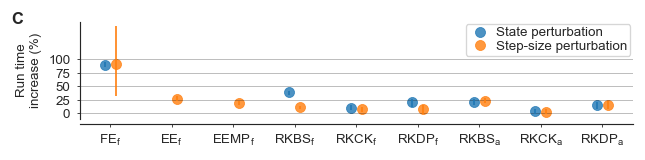

In [15]:
fig, ax = pltu.subplots(1, 1, ysizerow=1.2)
pltu.move_xaxis_outward(ax, scale=3)
pltu.set_labs(ax, panel_nums=['C'], panel_num_space=12, panel_num_va='top', panel_num_y=1.1)

pert_methods = ['conrad', 'abdulle_ln']

### Plot data ###
for i, pert_method in enumerate(pert_methods):

    if pert_method == 'conrad':
        label = 'State perturbation'
    elif pert_method == 'abdulle_ln':
        label = 'Step-size perturbation'
    else:
        raise ValueError

    positions = pltu.get_x_positions(n_positions=plot_df.shape[0], idx=i, n_idxs=len(pert_methods), offset=0.18)
    pltu.plot_percentiles(
        ax=ax, data=list(plot_df[f'{pert_method}_rel_run_times'].apply(lambda x: (x-1)*100)), positions=positions, connect=False,
        color=['C0', 'C1'][i], marker=['o', 'o'][i], nan_text=False, nans_kw=dict(ls='none'),
        mean_kw=dict(label=label, ls='None'), showflier=False
    )
    ax.set_xticks(np.arange(plot_df.shape[0]))
    ax.set_xticklabels(list(plot_df.solver), rotation=0)
    ax.set_yticks(np.arange(0, 101, 25))

### Decorate ###
ax.set_ylabel('Run time\nincrease (%)')
ax.legend(loc='upper right', frameon=True, bbox_to_anchor=(1,1), borderpad=0.2)
pltu.tight_layout()
despine()
pltu.grid(ax, axis='y')
pltu.savefig('fig7c')

## Text

In [ ]:
for (stim, solver), group in plot_df.groupby(['stim', 'solver'], sort=False):
    print(stim)
    method = solver.replace('\mathrm', '').replace('$', '')
    print(f"{method} \t {np.mean(np.concatenate(list(group.conrad_rel_run_times))-1)*100:.0f}")

In [ ]:
for adaptive, group in plot_df.groupby(['adaptive'], sort=False):
    print(f"{adaptive} \t {np.mean(np.concatenate(list(group.conrad_rel_run_times))-1)*100:.0f}")

In [ ]:
print(f"{adaptive} \t {np.nanmean(np.concatenate(list(plot_df.conrad_rel_run_times))-1)*100:.0f}")

In [ ]:
print(f"{adaptive} \t {np.nanmean(np.concatenate(list(plot_df.abdulle_rel_run_times))-1)*100:.0f}")

In [ ]:
print(f"{adaptive} \t {np.nanmean(np.concatenate(list(plot_df.abdulle_ln_rel_run_times))-1)*100:.0f}")

In [ ]:
for solver, group in plot_df.groupby(['solver'], sort=False):
    method = solver.replace('\mathrm', '').replace('$', '')
    print(f"{method} \t {np.mean(np.concatenate(list(group.abdulle_rel_run_times)))*100:.0f}")

In [ ]:
for adaptive, group in plot_df.groupby(['adaptive'], sort=False):
    print(f"{adaptive} \t {np.mean(np.concatenate(list(group.abdulle_rel_run_times)))*100:.0f}")

In [ ]:
for solver, group in plot_df.groupby(['solver'], sort=False):
    method = solver.replace('\mathrm', '').replace('$', '')
    print(f"{method} \t {np.mean(np.concatenate(list(group.abdulleln_rel_run_times)))*100:.0f}")

In [ ]:
for adaptive, group in plot_df.groupby(['adaptive'], sort=False):
    print(f"{adaptive} \t {np.mean(np.concatenate(list(group.abdulleln_rel_run_times)))*100:.0f}")